In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import bbknn
import statsmodels.api as sm
import gseapy as gp
import phenograph as pg
import ternary

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


In [7]:
%R library(Seurat)
%R library(SingleCellExperiment)
%R library(scran)
%R library(DropletUtils)
%R library(DESeq2)

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted

array(['DESeq2', 'DropletUtils', 'scran', 'SingleCellExperiment',
       'SummarizedExperiment', 'DelayedArray', 'BiocParallel',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'Seurat', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U20')

In [8]:
from TenX_PDAC_misc_scripts_v1_0 import *
from TenX_PDAC_plot_v1_0 import *
from TenX_PDAC_mann_whitney_u_v1_0 import *

In [9]:
#exp_id = create_ID()

In [10]:
exp_id = '202110251102'
path_input = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_input/'
path_output = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_PDAC_Lgr5/figures/v3/'

In [11]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}
cmap_tumor = {'autochthonous':'#d95f02', 'fragment_transplant':'#1b9e77', 'sorted_transplant':'#7570b3',
              '2D':'#e7298a','3D_2%':'#66a61e','3D_Tuv':'#e6ab02',}
cmap_treatment = {'3d_TAM':'#addd8e','10d_Veh':'#31a354','20d_TAM':'#006837',
                  '10d_LGK':'#fd8d3c','20d_LGK':'#bd0026','10d_Gem':'#2c7fb8'}
cmap_lineage_tracing = {'tdTomato': '#d95f02', 'Negative': 'silver', 'tdTomato-GFP': '#e6ab02', 'GFP': '#66a61e'}

# Initialize engines

In [12]:
c = Client()

In [13]:
dview = c[:]

In [14]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/")')
dview.execute('from TenX_PDAC_misc_scripts_v1_0 import *')
dview.execute('from TenX_PDAC_plot_v1_0 import *')
dview.execute('from TenX_PDAC_mann_whitney_u_v1_0 import *')

<AsyncResult: execute>

# Clustering of all cells

In [15]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

In [19]:
len(X.obs_names)

150699

In [32]:
X.X = X.layers['norm_log2']

## Feature selection - gene filtering

In [17]:
g_sel = X.var[(X.var['mean_counts']>0.1) & (X.var['n_cells_by_counts']>(len(X.obs_names)*0.1))].index

In [18]:
len(g_sel)

7935

In [19]:
Xs = X[:,g_sel]

## Feature selection - VST

In [20]:
pdX = sc2pd(Xs, 'raw')

In [21]:
feat = select_features_vst(pdX, 2500)

In [22]:
Xs = X[:,feat]

## Dimensionality reduction - PCA

In [23]:
pdX = sc2pd(Xs, 'norm_log2')

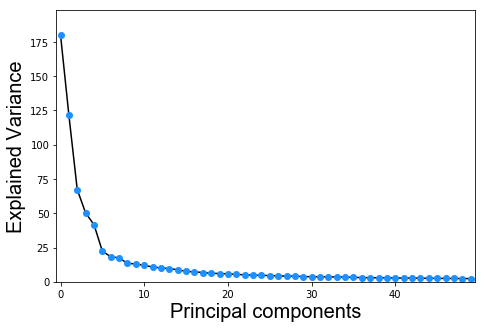

In [24]:
draw_pca_explained_var(pdX)

In [25]:
pca = dim_reduc(pdX, dim=30, method='PCA')

In [26]:
Xs.obsm['X_pca'] = np.array(pca).T

## UMAP - bbknn, PCA

In [27]:
bbknn.bbknn(Xs, batch_key='mouse', neighbors_within_batch=5, use_rep='X_pca',metric='euclidean')

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [28]:
sc.tl.umap(Xs, min_dist=1, spread=3)

In [29]:
Xs.obsm['X_umap_pca_bbknn'] = Xs.obsm['X_umap']

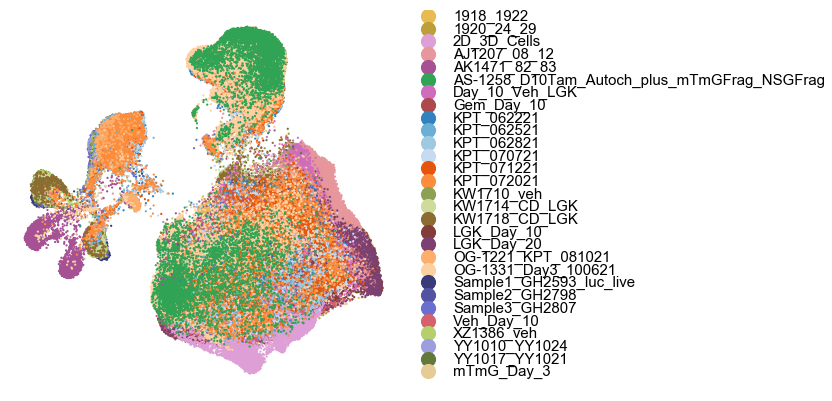

In [30]:
draw_scatter_groups(Xs.obsm['X_umap_pca_bbknn'], 
                    Xs.obs['batch'], 
                    {g:plt.cm.tab20b(i/20) if i<20 else plt.cm.tab20c((i-20)/20) for i, g in enumerate(return_unique(Xs.obs['batch']))},
                    s=5, show_axes = False)

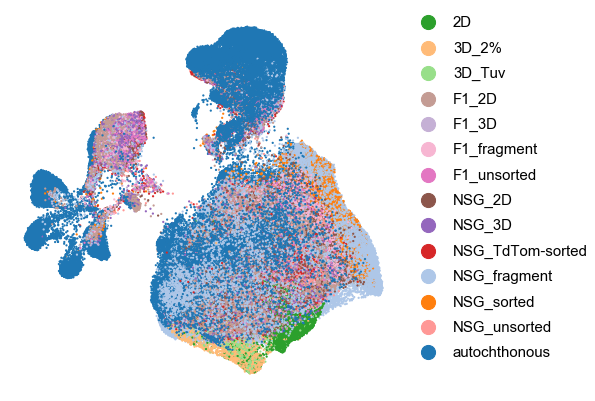

In [31]:
draw_scatter_groups(Xs.obsm['X_umap_pca_bbknn'], 
                    Xs.obs['tumor'],
                    s=5, show_axes = False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

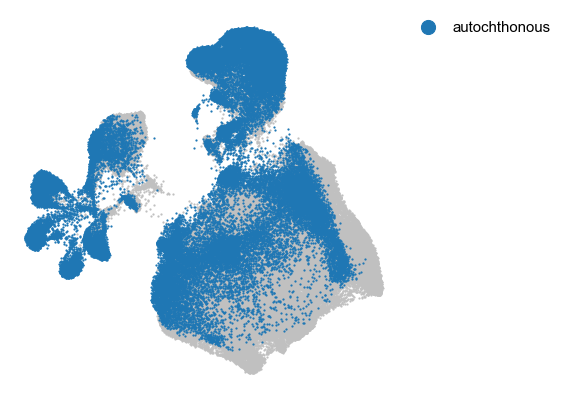

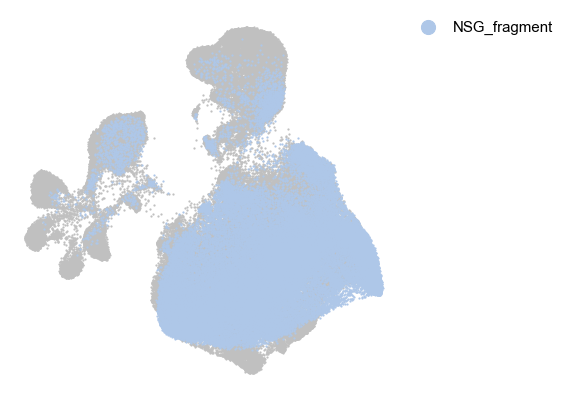

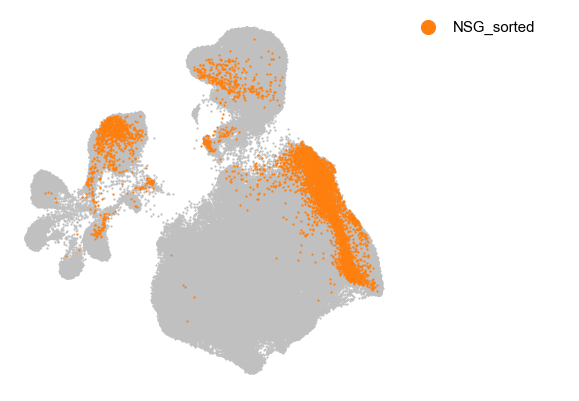

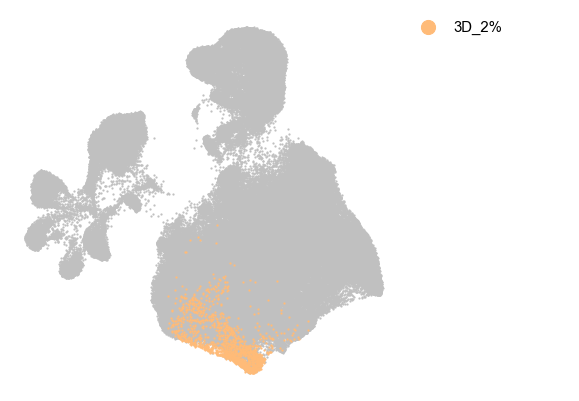

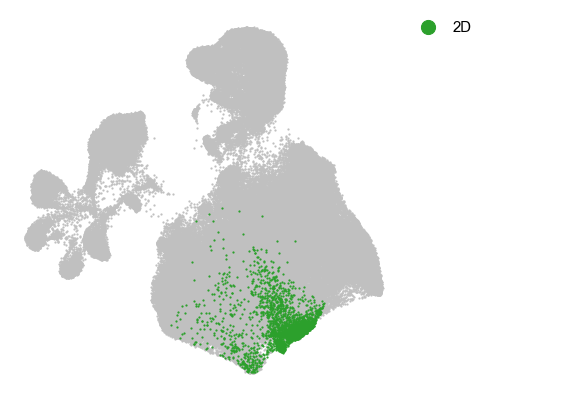

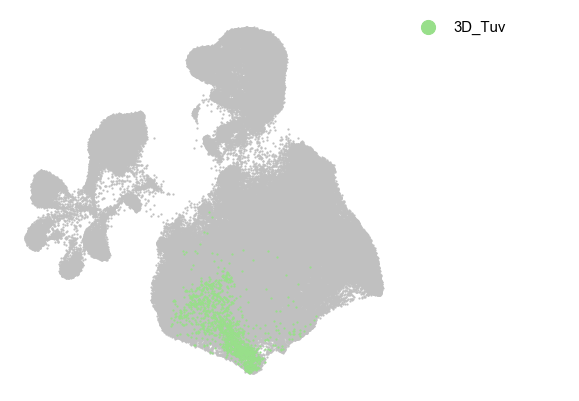

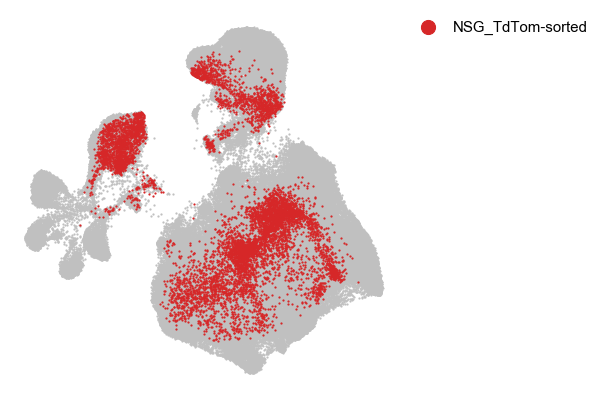

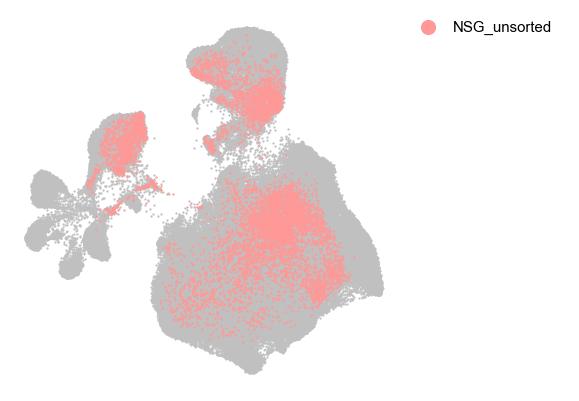

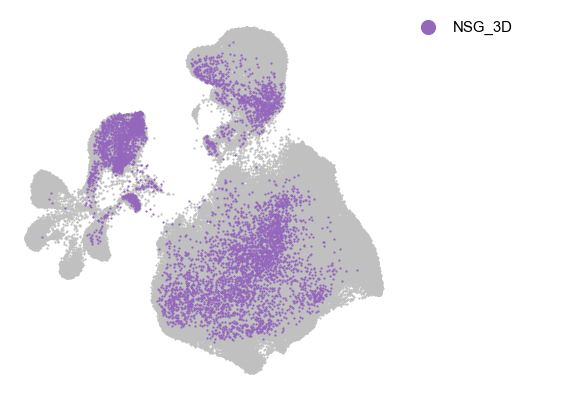

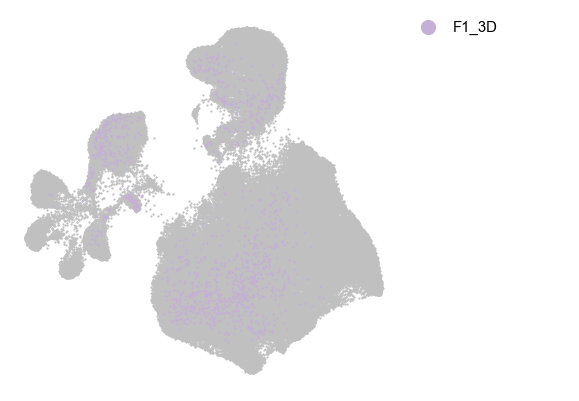

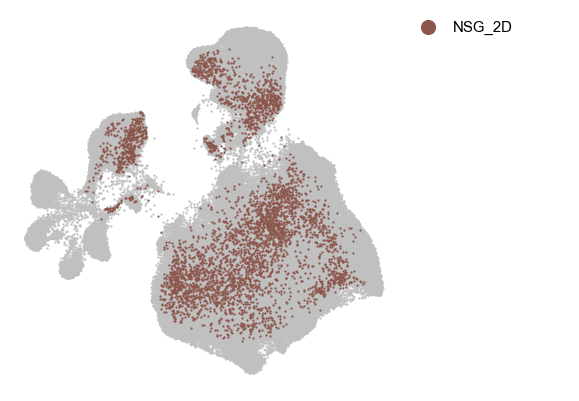

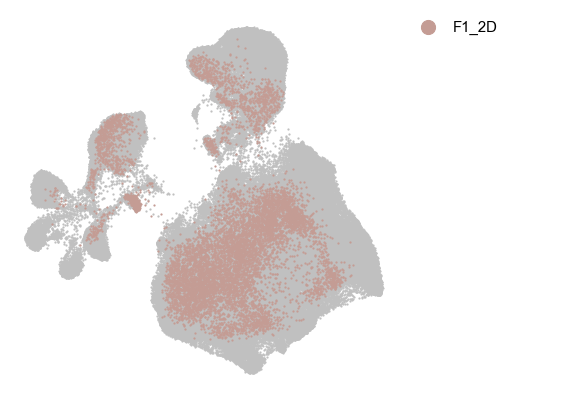

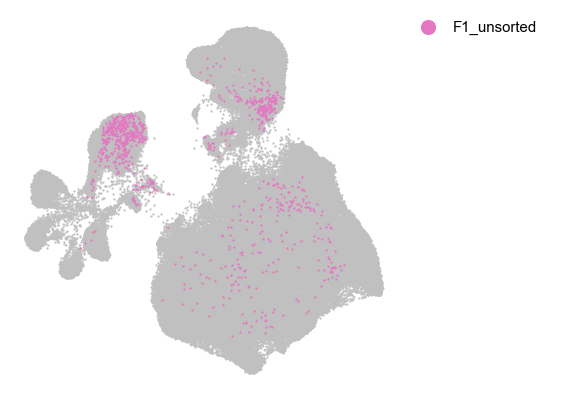

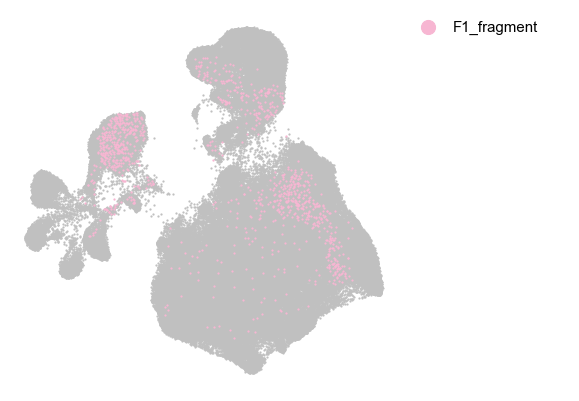

In [32]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca_bbknn'], 
                               Xs.obs['tumor'],
                               s=5, show_axes = False)

## Marker gene expression

In [33]:
pdX = sc2pd(X, 'raw_log2')

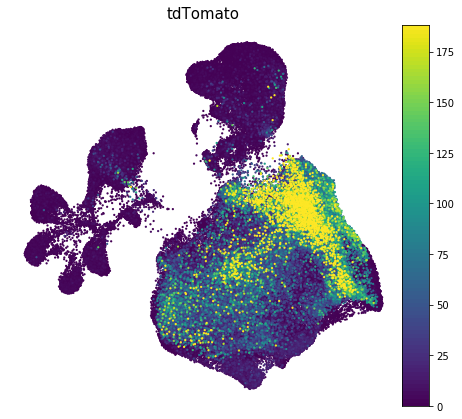

In [34]:
g = 'tdTomato'
expr = Xs.obs[g]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

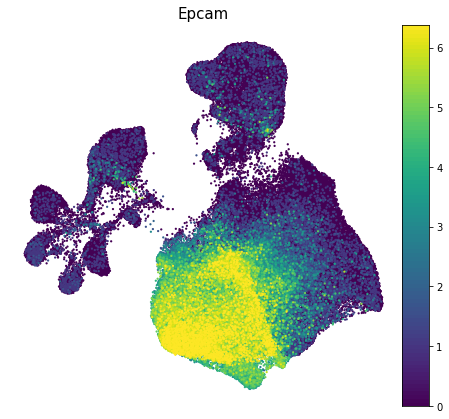

In [35]:
g = 'Epcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

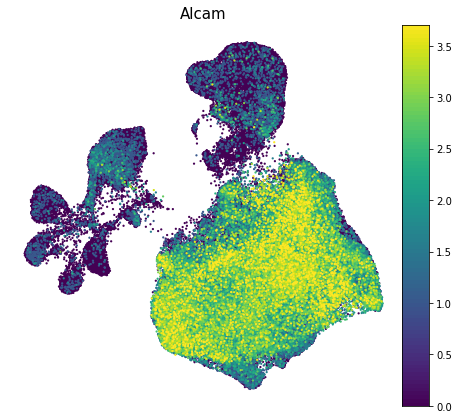

In [36]:
g = 'Alcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

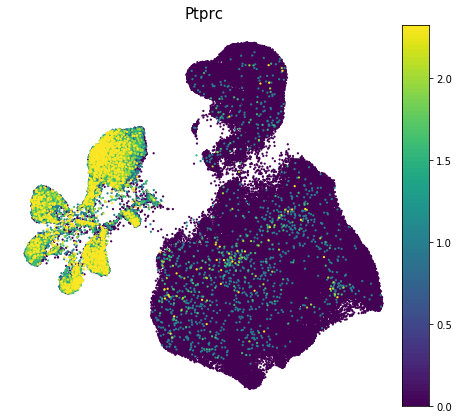

In [37]:
g = 'Ptprc'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

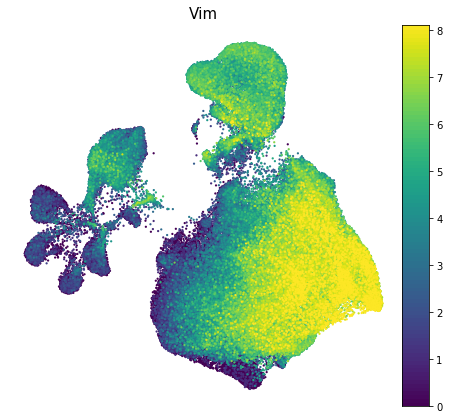

In [38]:
g = 'Vim'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

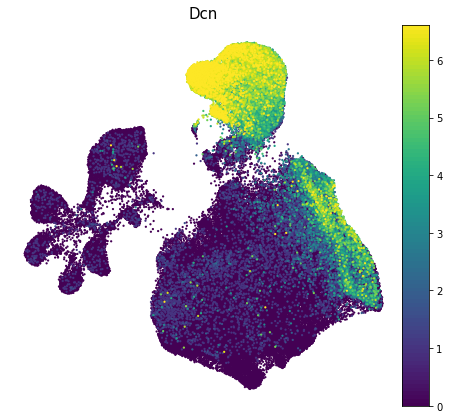

In [39]:
g = 'Dcn'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

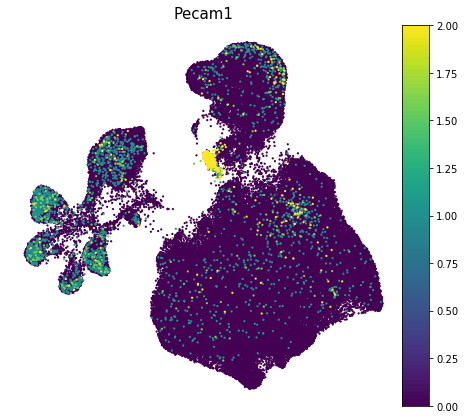

In [40]:
g = 'Pecam1'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  0,
                  2,
                  text = g,
                  s = 5, show_axes=False)

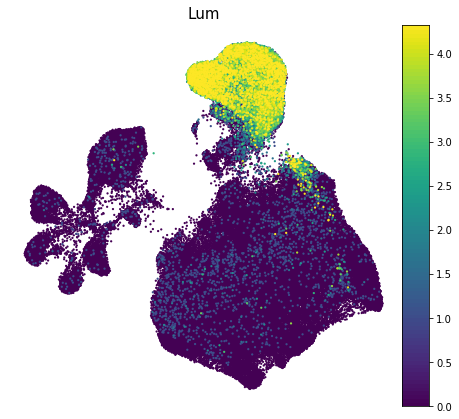

In [41]:
g = 'Lum'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

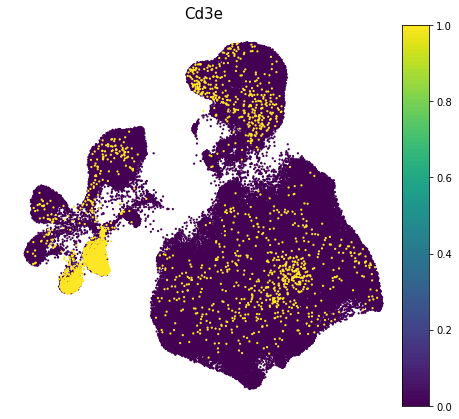

In [42]:
g = 'Cd3e'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

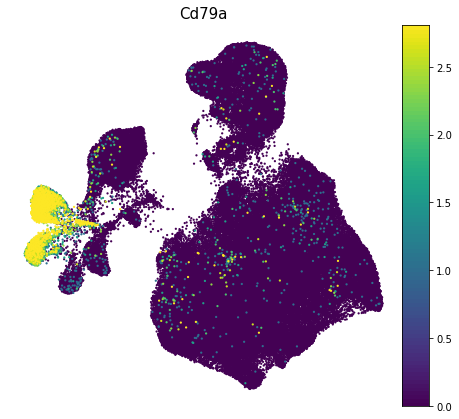

In [43]:
g = 'Cd79a'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

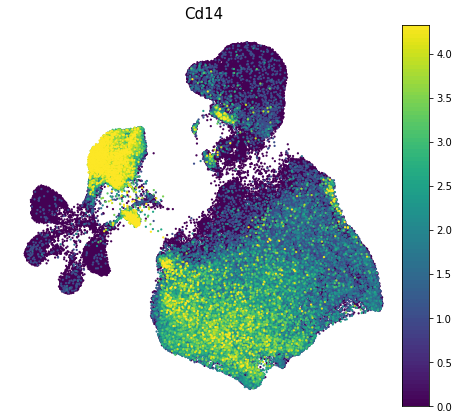

In [44]:
g = 'Cd14'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

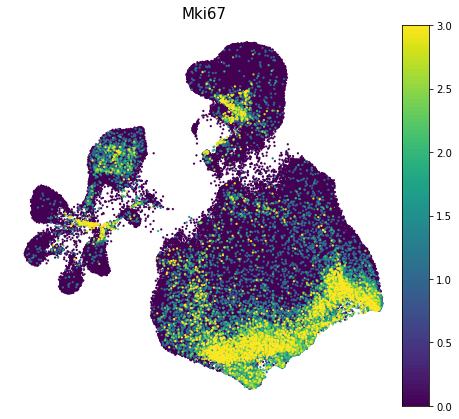

In [45]:
g = 'Mki67'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_pca_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

## Leiden clustering

In [46]:
sc.tl.leiden(Xs, resolution = 0.25)

In [47]:
len(set(Xs.obs['leiden']))

6

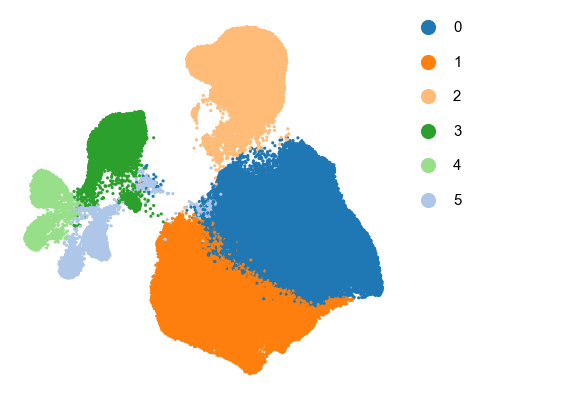

In [48]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    Xs.obs['leiden'], 
                    s=10, show_axes=False)

## Assign cluster identities

In [49]:
cl_all = pd.Series('Epithelial cells', index = Xs.obs_names)

# alveolar macrophages
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['3'])].index:
    cl_all[c] = 'Macrophages'
    
#T cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['5'])].index:
    cl_all[c] = 'T-cells'
    
#B cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['4'])].index:
    cl_all[c] = 'B-cells'
    
#Fibroblasts
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['2'])].index:
    cl_all[c] = 'Fibroblasts'

In [50]:
Counter(cl_all)

Counter({'Epithelial cells': 104264,
         'T-cells': 5411,
         'Fibroblasts': 23583,
         'Macrophages': 11191,
         'B-cells': 6250})

In [51]:
Xs.obs['cl_all_pca'] = cl_all

In [22]:
cmap_cl_all = {'Macrophages':'#1b9e77',
               'B-cells':'#7570b3',
               'Epithelial cells':'#d95f02',
               'Fibroblasts':'#e7298a',
               'T-cells':'#66a61e', 
               'Endothelial cells':'#e6ab02'}

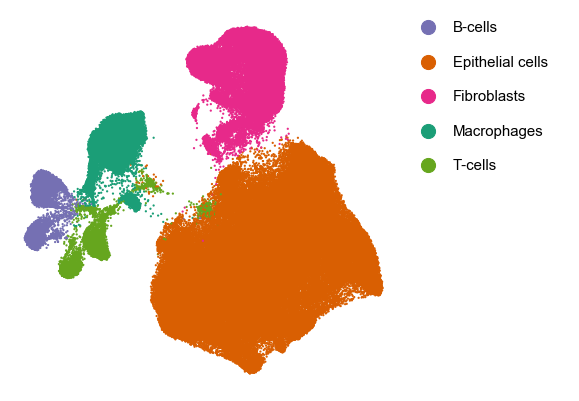

In [54]:
draw_scatter_groups(Xs.obsm['X_umap_pca_bbknn'], 
                    Xs.obs['cl_all_pca'],
                    cmap_cl_all,
                    s=5, show_axes=False)

## Checkpoint

In [55]:
#Xs.write_h5ad('%s/%s_Xs_PDAC_Lgr5_all.h5' % (path_output, exp_id))

... storing 'cl_all_pca' as categorical


In [33]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

In [34]:
X.X = X.layers['norm_log2']

In [15]:
Xs = sc.read_h5ad('%s/%s_Xs_PDAC_Lgr5_all.h5' % (path_output, exp_id))

## Dimensionality reduction - NMF

In [17]:
pdX = sc2pd(Xs, 'norm_log2')

In [18]:
nmf = dim_reduc(pdX, dim=50, method='NMF')

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [19]:
Xs.obsm['X_nmf'] = np.array(nmf).T

## UMAP - bbknn, NMF

In [24]:
bbknn.bbknn(Xs, batch_key='mouse', neighbors_within_batch=5, use_rep='X_nmf',metric='euclidean')

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [25]:
sc.tl.umap(Xs, min_dist=1, spread=3)

In [26]:
Xs.obsm['X_umap_nmf_bbknn'] = Xs.obsm['X_umap']

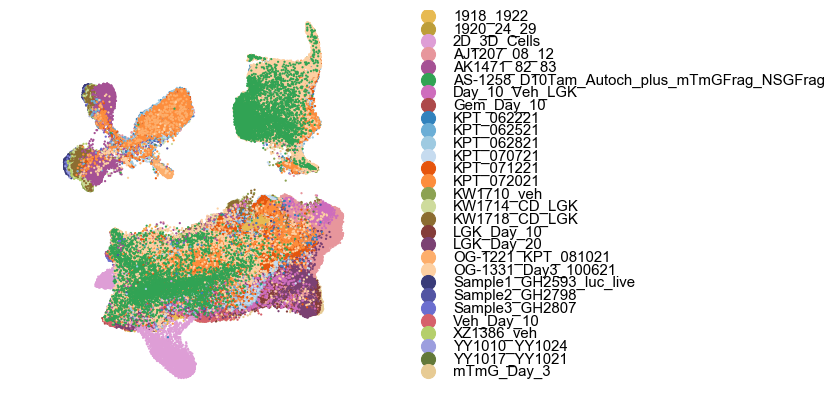

In [27]:
draw_scatter_groups(Xs.obsm['X_umap_nmf_bbknn'], 
                    Xs.obs['batch'], 
                    {g:plt.cm.tab20b(i/20) if i<20 else plt.cm.tab20c((i-20)/20) for i, g in enumerate(return_unique(Xs.obs['batch']))},
                    s=5, show_axes = False)

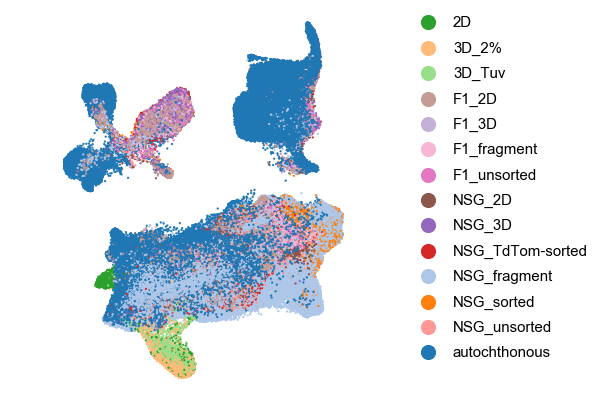

In [28]:
draw_scatter_groups(Xs.obsm['X_umap_nmf_bbknn'], 
                    Xs.obs['tumor'],
                    s=5, show_axes = False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

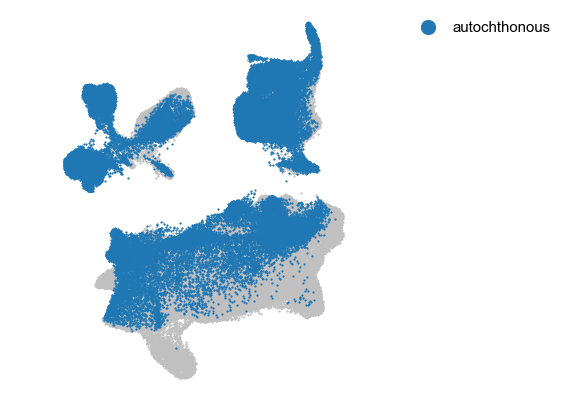

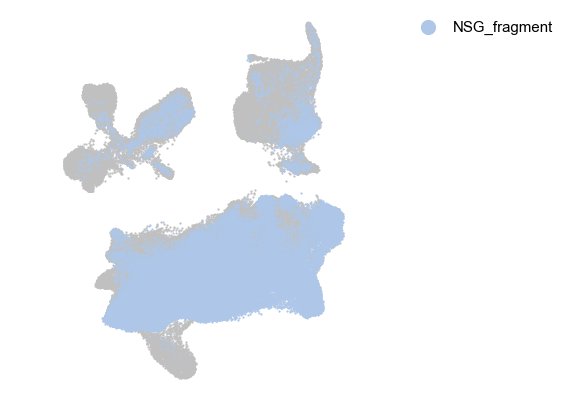

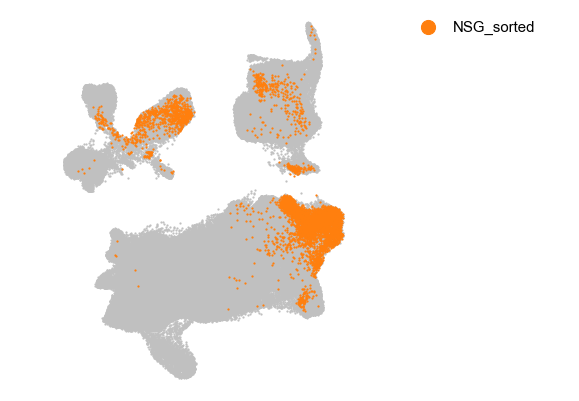

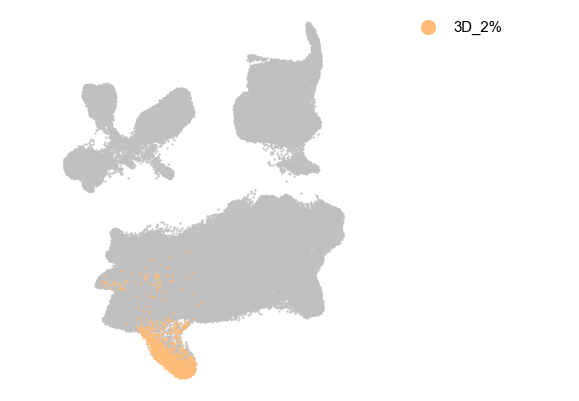

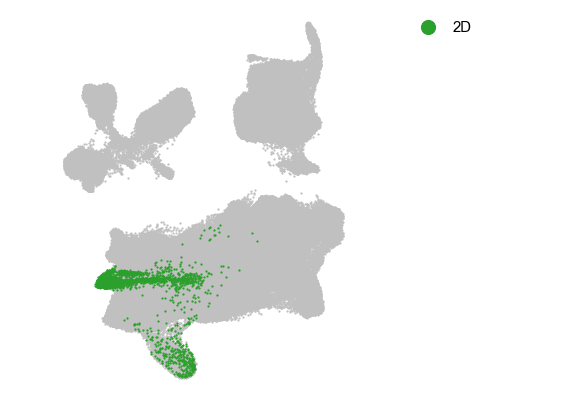

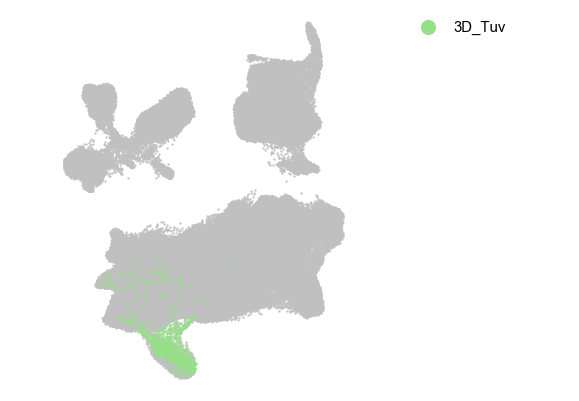

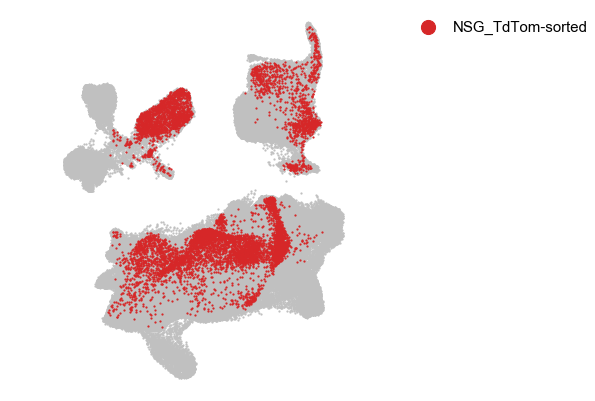

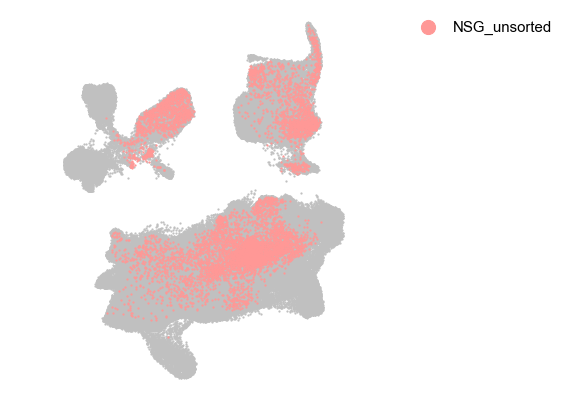

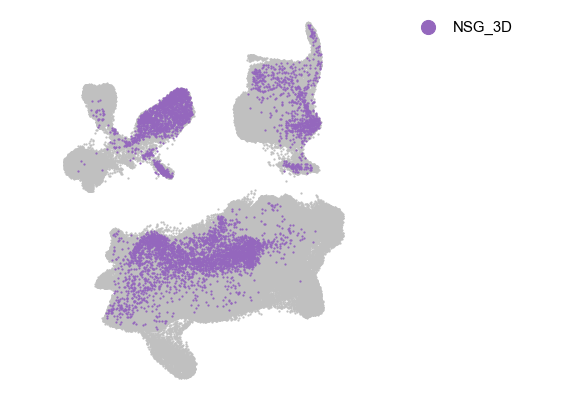

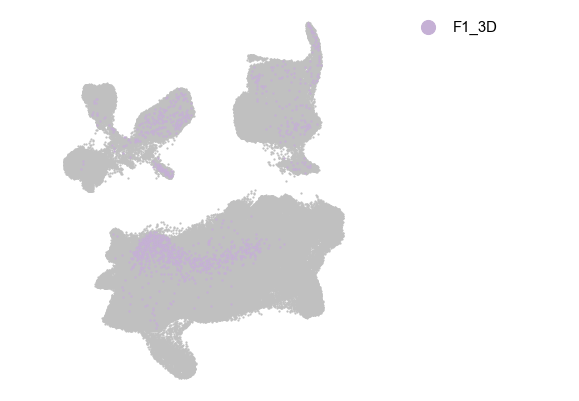

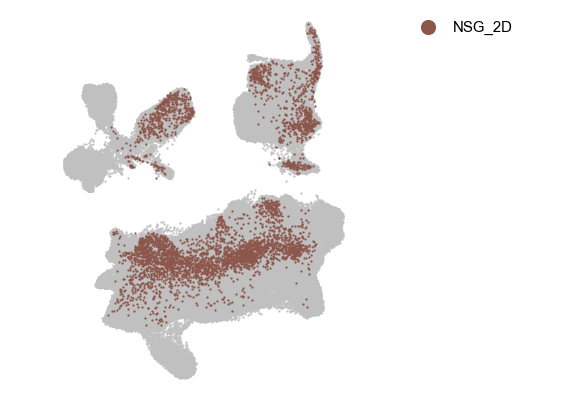

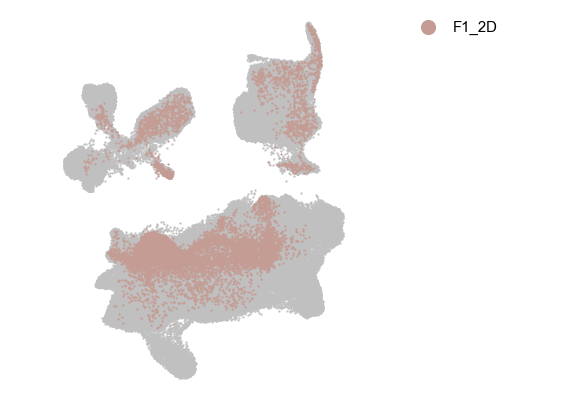

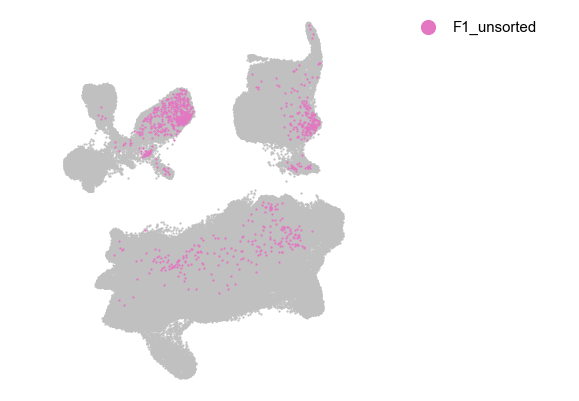

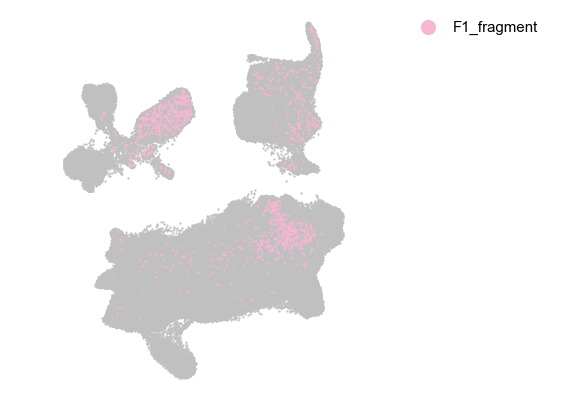

In [29]:
draw_scatter_groups_individual(Xs.obsm['X_umap_nmf_bbknn'], 
                               Xs.obs['tumor'],
                               s=5, show_axes = False)

## Marker gene expression

In [35]:
pdX = sc2pd(X, 'raw_log2')

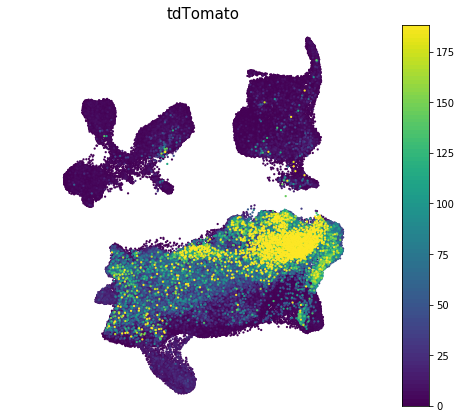

In [36]:
g = 'tdTomato'
expr = Xs.obs[g]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

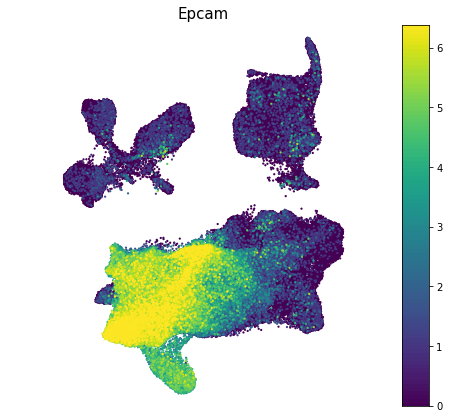

In [37]:
g = 'Epcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

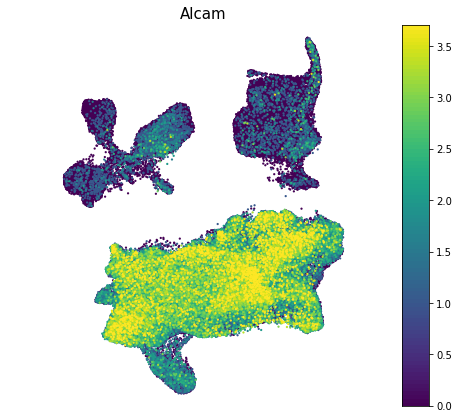

In [38]:
g = 'Alcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

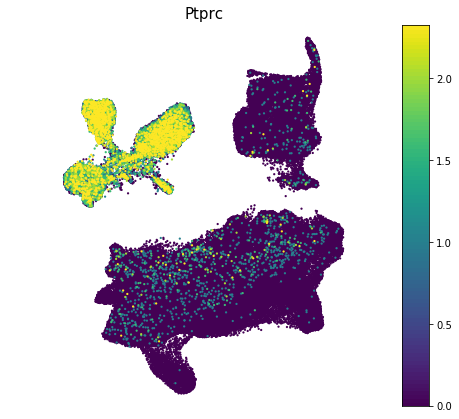

In [39]:
g = 'Ptprc'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

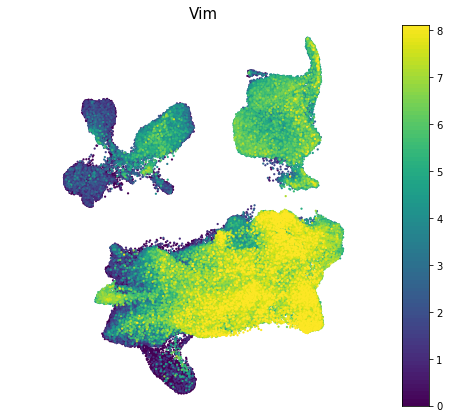

In [40]:
g = 'Vim'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

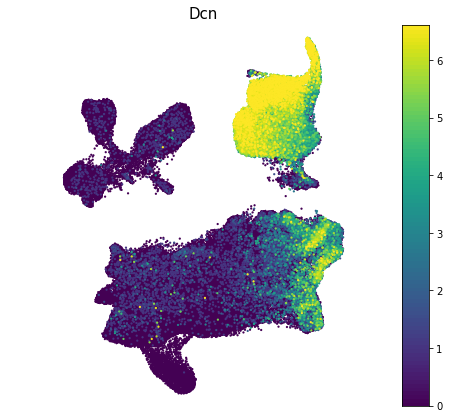

In [41]:
g = 'Dcn'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

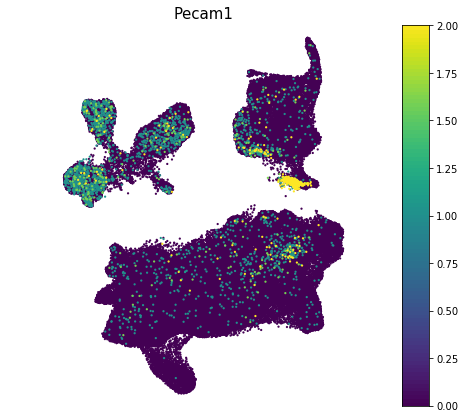

In [42]:
g = 'Pecam1'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  0,
                  2,
                  text = g,
                  s = 5, show_axes=False)

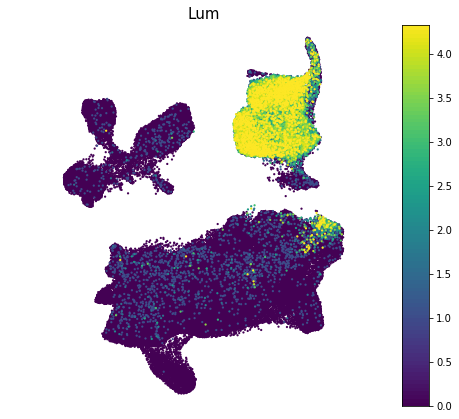

In [43]:
g = 'Lum'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

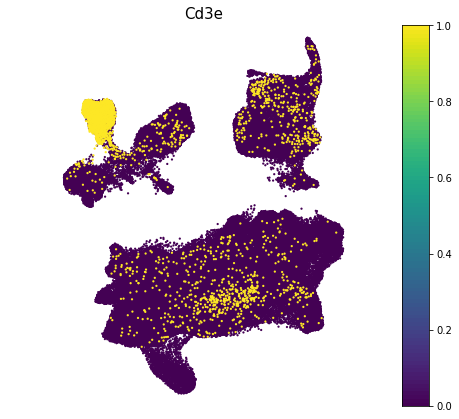

In [44]:
g = 'Cd3e'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

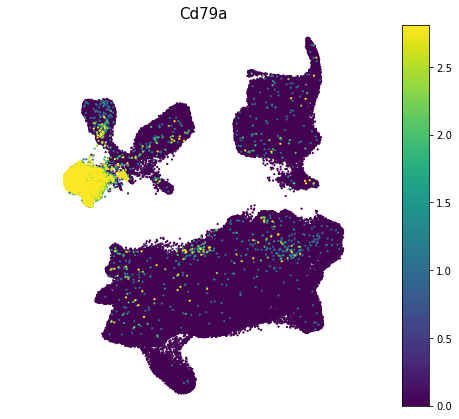

In [45]:
g = 'Cd79a'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

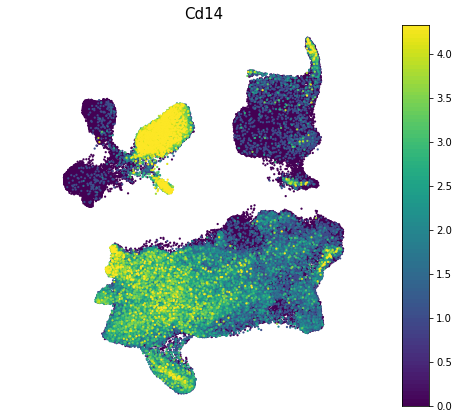

In [46]:
g = 'Cd14'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

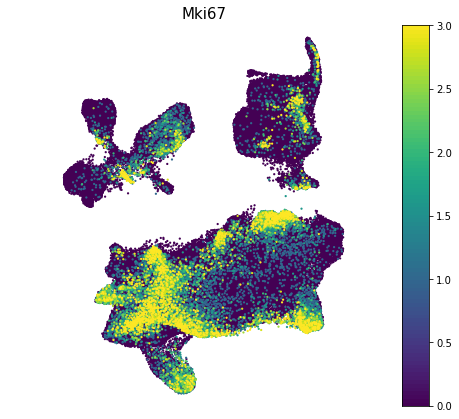

In [47]:
g = 'Mki67'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap_nmf_bbknn'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

## Leiden clustering

In [48]:
sc.tl.leiden(Xs, resolution = 0.25)

In [49]:
len(set(Xs.obs['leiden']))

8

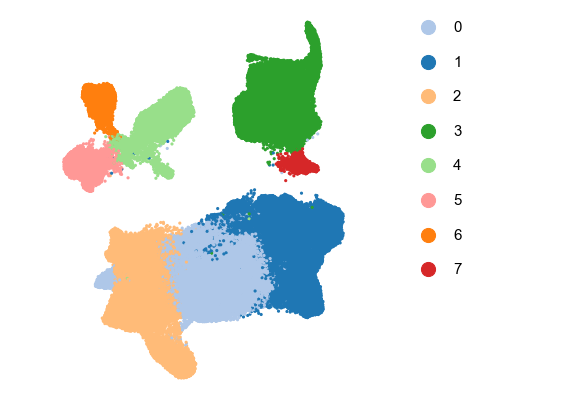

In [51]:
draw_scatter_groups(Xs.obsm['X_umap_nmf_bbknn'], 
                    Xs.obs['leiden'], 
                    s=10, show_axes=False)

## Assign cluster identities

In [52]:
cl_all = pd.Series('Epithelial cells', index = Xs.obs_names)

# alveolar macrophages
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['4'])].index:
    cl_all[c] = 'Macrophages'
    
#T cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['6'])].index:
    cl_all[c] = 'T-cells'
    
#B cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['5'])].index:
    cl_all[c] = 'B-cells'
    
#Fibroblasts
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['3'])].index:
    cl_all[c] = 'Fibroblasts'
    
#Endothelial cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['7'])].index:
    cl_all[c] = 'Endothelial cells'

In [53]:
Counter(cl_all)

Counter({'Epithelial cells': 104588,
         'T-cells': 4412,
         'Fibroblasts': 21632,
         'Macrophages': 11845,
         'Endothelial cells': 1970,
         'B-cells': 6252})

In [54]:
Xs.obs['cl_all_nmf'] = cl_all

In [55]:
cmap_cl_all = {'Macrophages':'#1b9e77',
               'B-cells':'#7570b3',
               'Epithelial cells':'#d95f02',
               'Fibroblasts':'#e7298a',
               'T-cells':'#66a61e', 
               'Endothelial cells':'#e6ab02'}

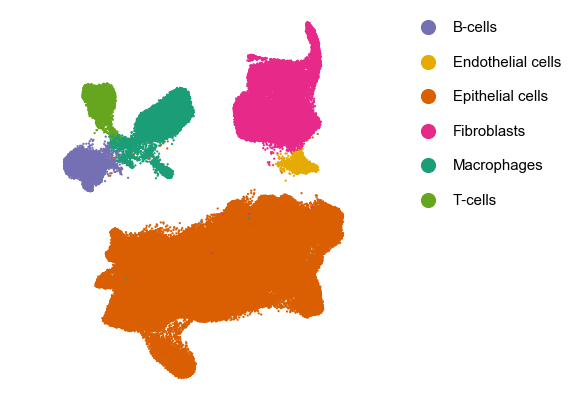

In [56]:
draw_scatter_groups(Xs.obsm['X_umap_nmf_bbknn'], 
                    Xs.obs['cl_all_nmf'],
                    cmap_cl_all,
                    s=5, show_axes=False)

## Checkpoint

In [58]:
#Xs.write_h5ad('%s/%s_Xs_PDAC_Lgr5_all.h5' % (path_output, exp_id))

... storing 'cl_all_nmf' as categorical
